# **Clean and Prep Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive
from keras.utils import timeseries_dataset_from_array

# Mount Google Drive containing data
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_datasets():
    raw_gusts = pd.read_csv('/content/drive/MyDrive/Windspeed-timeseries/K2WX-gusts.csv')
    raw_mins = pd.read_csv('/content/drive/MyDrive/Windspeed-timeseries/K2WX.csv')
    raw_gusts['utc'] = pd.to_datetime(raw_gusts['utc'])
    raw_mins['UTC'] = pd.to_datetime(raw_mins['UTC'])
    raw_mins.drop(columns=['Unnamed: 0', 'tags', 'Prcp'], inplace=True)
    return raw_mins, raw_gusts

In [ ]:
def get_storm_events(df):
    storm_gusts = df[df['Class'].isin([3, 4, 5])].copy()
    return storm_gusts

In [ ]:
def cyclical_encoding_helper(df):
    """Cyclical encoding for the periodic time series features."""
    features_to_encode = ['hour', 'month']
    for feature in features_to_encode:
        period = len(df[feature].unique())
        if df[feature].min() == 1:
            angles = (df[feature] - 1) * (2 * np.pi / period)
        else:
            angles = (df[feature]) * (2 * np.pi / period)
        sin_feature = np.sin(angles)
        cos_feature = np.cos(angles)
        df[feature + '_sin'] = sin_feature
        df[feature + '_cos'] = cos_feature
    df.drop(columns=features_to_encode, inplace=True)
    df.drop(columns='UTC', inplace=True)
    return df

In [ ]:
def add_timeseries_features(df):
    """Adds time-series relevant features: month of the year, hour of the day."""
    df['hour'] = df['UTC'].dt.hour
    df['month'] = df['UTC'].dt.month
    df = cyclical_encoding_helper(df)
    return df

In [ ]:
def transform_wind_to_xy(df):
    spd = df['Spd']
    drn_rad = df.pop('Drn') * np.pi / 180
    df['Spd_x'] = spd * np.cos(drn_rad)
    df['Spd_y'] = spd * np.sin(drn_rad)
    gspd = df.pop('gSpd')
    gdrn_rad = df.pop('gDrn') * np.pi / 180
    df['gSpd_x'] = gspd * np.cos(gdrn_rad)
    df['gSpd_y'] = gspd * np.sin(gdrn_rad)
    return df

In [ ]:
raw_mins, raw_gusts = load_datasets()           # Will give a DtypeWarning, but this column is
                                                # unnecesary and is dropped from the analysis

storm_gusts = get_storm_events(raw_gusts)       # To match up correctly storm_gusts
storm_gusts['indx'] = storm_gusts['indx'] - 1   # indices must be shifted back by 1

mins_data = add_timeseries_features(raw_mins.copy())
mins_data = transform_wind_to_xy(mins_data)

<ipython-input-2-70ba62a61c3c>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_mins = pd.read_csv('/content/drive/MyDrive/Windspeed-timeseries/K2WX.csv')


In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
mins_data.describe()

,Spd,Tdry,Tdew,Qfe,hour_sin,hour_cos,month_sin,month_cos,Spd_x,Spd_y,gSpd_x,gSpd_y
count,8173571.00,8176710.00,8176693.00,8176710.00,9113547.00,9113547.00,9113547.00,9113547.00,8173571.00,8173571.00,8173571.00,8173571.00
mean,10.99,46.04,31.63,26.80,-0.00,0.00,0.01,-0.01,1.55,-2.73,1.75,-3.09
std,6.84,22.76,17.66,0.19,0.71,0.71,0.71,0.70,8.08,9.62,9.55,11.25
min,0.00,-29.00,-52.00,25.95,-1.00,-1.00,-1.00,-1.00,-46.97,-65.64,-141.60,-97.27
25%,6.00,30.00,20.00,26.68,-0.71,-0.71,-0.50,-0.87,-3.61,-8.98,-4.21,-10.20
50%,10.00,46.00,31.00,26.81,0.00,0.00,0.00,-0.00,0.78,-2.27,0.94,-2.72
75%,14.00,63.00,46.00,26.93,0.71,0.71,0.87,0.50,6.63,4.23,7.63,4.91
max,68.00,124.00,91.00,27.65,1.00,1.00,1.00,1.00,48.77,42.69,98.79,139.63


In [ ]:
# Z-score normalization of data
mins_means = mins_data.mean()
mins_stds = mins_data.std()
mins_scaled = (mins_data - mins_means) / mins_stds

# Will need these to unscale target speed inside function create_timeseries_data()
spd_mean = mins_means['Spd']
spd_std = mins_stds['Spd']

# Will need these to evaluate the null method for baseline metrics
spd_xmean = mins_means['Spd_x']
spd_xstd = mins_stds['Spd_x']
spd_ymean = mins_means['Spd_y']
spd_ystd = mins_stds['Spd_y']

The mean Spd across the entire mins_data is ~11, while the mean Spd across just the windows created from gusts is ~13, which is not a huge difference, meaning that this scaling method works fine.

In [ ]:
def format_timeseries_data(data, targets, past_mins=5, pred_gap=5):
    timeseries_data = timeseries_dataset_from_array(
        data=data[:-pred_gap],
        targets=targets[(past_mins + pred_gap - 1):],
        sequence_length=past_mins,
        shuffle=False)
    return timeseries_data

In [ ]:
def create_timeseries_data(mins_data, storm_gusts, window_size=60, past_mins=5, pred_gap=5):
    time_delta = int(window_size/2)
    concatenated_dataset = None

    for index, gust in storm_gusts.iterrows():
        index_of_peak = gust['indx']
        window_start = index_of_peak - (time_delta - 1)
        window_end = index_of_peak + time_delta
        window = mins_data.loc[window_start : window_end].copy()

        if window.isna().any().any():   # Skipping gust observations with any NA values in the mins_data
            continue

        target_spd = window.pop('Spd')
        target_spd = (target_spd * spd_std) + spd_mean   # Need to un-scale the response variable since it was passed in scaled

        timeseries_data = format_timeseries_data(window, target_spd, past_mins, pred_gap)

        if concatenated_dataset is None:
            concatenated_dataset = timeseries_data
        else:
            concatenated_dataset = concatenated_dataset.concatenate(timeseries_data)

    return concatenated_dataset

In [ ]:
# Partition storm gusts data into train, validation, and test
n = len(storm_gusts)
train_gusts = storm_gusts[:int(n*0.7)]
val_gusts = storm_gusts[int(n*0.7):int(n*0.9)]
test_gusts = storm_gusts[int(n*0.9):]

In [ ]:
# Takes 2 mins to run
train = create_timeseries_data(mins_scaled, train_gusts, window_size=60, past_mins=5, pred_gap=5)
val = create_timeseries_data(mins_scaled, val_gusts, window_size=60, past_mins=5, pred_gap=5)
test = create_timeseries_data(mins_scaled, test_gusts, window_size=60, past_mins=5, pred_gap=5)

# **Model Fitting**

The null model simply uses the last seen wind speed value as the prediction - this is used to establish a baseline for the evaluation metrics.

In [ ]:
def eval_null_method(dataset):
    total_abs_error = 0.
    samples_seen = 0
    for samples, targets in dataset:
        pred_x = samples[:, -1, 7]   # column 7 has Spd x component and 8 has the y component, use
        pred_y = samples[:, -1, 8]   # [-1] to get the most recent time_step as the naive prediction
        predictions = np.sqrt(pred_x**2 + pred_y**2)
        total_abs_error += np.sum(np.abs(predictions - targets))
        samples_seen += samples.shape[0]
    return total_abs_error / samples_seen

In [ ]:
print("Baseline Metrics")
print("----------------")
print(f"Validation MAE: {eval_null_method(val):.3f}")
print(f"Test MAE: {eval_null_method(test):.3f}")

Baseline Metrics
----------------
Validation MAE: 11.535
Test MAE: 10.801


The units for MAE are the same as the response variable (knots). This means our null model was off on average by 11 knots each minute in the window. Is this baseline reasonable? I think so.. the wind speed is highly variable during these gusts so this naive method should be bad.

In [ ]:
def compile_and_fit(model, save_name, max_epochs=20, patience=2):
    save_dir = '/content/drive/MyDrive/ColabNotebooks/Models/'

    callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
                 ModelCheckpoint(save_dir + save_name + '.keras', save_best_only=True)]

    model.compile(loss=keras.losses.MeanSquaredError(),
                optimizer=keras.optimizers.RMSprop(),
                metrics=[keras.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs,
                      validation_data=val,
                      callbacks=callbacks)
    return history

In [ ]:
linear = keras.Sequential([
    keras.layers.Flatten(input_shape=(5 * 11,)),
    keras.layers.Dense(units=1)
])

linear_history = compile_and_fit(linear, save_name='linear')

In [ ]:
linear_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/linear.keras')
print(f"Validation MAE: {linear_model.evaluate(val)[1]:.3f}")
print(f"Test MAE: {linear_model.evaluate(test)[1]:.3f}")

188/188 [==============================] - 6s 32ms/step - loss: 23.0912 - mean_absolute_error: 3.8553
Validation MAE: 3.855
92/92 [==============================] - 5s 50ms/step - loss: 24.6042 - mean_absolute_error: 3.9916
Test MAE: 3.992


In [ ]:
dense1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(5 * 11,)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=1)
])

dense1_history = compile_and_fit(dense1, save_name='dense1')

In [ ]:
dense1_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/dense1.keras')
print(f"Validation MAE: {dense1_model.evaluate(val)[1]:.3f}")
print(f"Test MAE: {dense1_model.evaluate(test)[1]:.3f}")

188/188 [==============================] - 8s 43ms/step - loss: 9.3499 - mean_absolute_error: 2.3895
Validation MAE: 2.390
92/92 [==============================] - 3s 33ms/step - loss: 9.0883 - mean_absolute_error: 2.3340
Test MAE: 2.334


In [ ]:
dense2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(5 * 11,)),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=1)
])

dense2_history = compile_and_fit(dense2, save_name='dense2')

In [ ]:
dense2_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/dense2.keras')
print(f"Validation MAE: {dense2_model.evaluate(val)[1]:.3f}")
print(f"Test MAE: {dense2_model.evaluate(test)[1]:.3f}")

188/188 [==============================] - 8s 40ms/step - loss: 9.7524 - mean_absolute_error: 2.4569
Validation MAE: 2.457
92/92 [==============================] - 3s 33ms/step - loss: 9.7556 - mean_absolute_error: 2.4203
Test MAE: 2.420


In [ ]:
lstm1 = keras.Sequential([
    keras.layers.LSTM(units=16, recurrent_dropout=0.15),
    keras.layers.Dense(units=1)
])

lstm1_history = compile_and_fit(lstm1, save_name='lstm1')

In [ ]:
model1 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/lstm1.keras')
print(f"Validation MAE: {model1.evaluate(val)[1]:.3f}")
print(f"Test MAE: {model1.evaluate(test)[1]:.3f}")

188/188 [==============================] - 8s 41ms/step - loss: 25.1939 - mean_absolute_error: 4.0001
Validation MAE: 4.000
92/92 [==============================] - 3s 32ms/step - loss: 24.7244 - mean_absolute_error: 3.8306
Test MAE: 3.831


In [ ]:
lstm2 = keras.Sequential([
    keras.layers.LSTM(units=64, recurrent_dropout=0.15),
    keras.layers.Dense(units=1)
])

lstm2_history = compile_and_fit(lstm2, 'lstm2')

In [ ]:
model2 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/lstm2.keras')
print(f"Validation MAE: {model2.evaluate(val)[1]:.3f}")
print(f"Test MAE: {model2.evaluate(test)[1]:.3f}")

188/188 [==============================] - 7s 34ms/step - loss: 9.7501 - mean_absolute_error: 2.4591
Validation MAE: 2.459
92/92 [==============================] - 3s 32ms/step - loss: 9.4759 - mean_absolute_error: 2.3937
Test MAE: 2.394


In [ ]:
lstm3 = keras.Sequential([
    keras.layers.LSTM(units=16, recurrent_dropout=0.15, return_sequences=True),
    keras.layers.LSTM(units=16, recurrent_dropout=0.15),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=1)
])

lstm3_history = compile_and_fit(lstm3, save_name='lstm3')

In [ ]:
model3 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/lstm3.keras')
print(f"Validation MAE: {model3.evaluate(val)[1]:.3f}")
print(f"Test MAE: {model3.evaluate(test)[1]:.3f}")

188/188 [==============================] - 7s 35ms/step - loss: 20.6844 - mean_absolute_error: 3.6632
Validation MAE: 3.663
92/92 [==============================] - 5s 50ms/step - loss: 20.2966 - mean_absolute_error: 3.6066
Test MAE: 3.607


In [ ]:
lstm4 = keras.Sequential([
    keras.layers.LSTM(units=64, recurrent_dropout=0.15, return_sequences=True),
    keras.layers.LSTM(units=64, recurrent_dropout=0.15),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=1)
])

lstm4_history = compile_and_fit(lstm4, save_name='lstm4')

In [ ]:
model4 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/lstm4.keras')
print(f"Validation MAE: {model4.evaluate(val)[1]:.3f}")
print(f"Test MAE: {model4.evaluate(test)[1]:.3f}")

188/188 [==============================] - 9s 43ms/step - loss: 9.9831 - mean_absolute_error: 2.5083
Validation MAE: 2.508
92/92 [==============================] - 3s 34ms/step - loss: 10.1691 - mean_absolute_error: 2.4958
Test MAE: 2.496


In [ ]:
lstm5 = keras.Sequential([
    keras.layers.LSTM(units=256, recurrent_dropout=0.15, return_sequences=True),
    keras.layers.LSTM(units=256, recurrent_dropout=0.15, return_sequences=True),
    keras.layers.LSTM(units=256, recurrent_dropout=0.15, return_sequences=True),
    keras.layers.LSTM(units=256, recurrent_dropout=0.15, return_sequences=True),
    keras.layers.LSTM(units=256, recurrent_dropout=0.15),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(units=1)
])

lstm5_history = compile_and_fit(lstm5, save_name='lstm5')

In [ ]:
model5 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/lstm5.keras')
print(f"Validation MAE: {model5.evaluate(val)[1]:.3f}")
print(f"Test MAE: {model5.evaluate(test)[1]:.3f}")

188/188 [==============================] - 23s 114ms/step - loss: 9.3851 - mean_absolute_error: 2.4026
Validation MAE: 2.403
92/92 [==============================] - 11s 114ms/step - loss: 9.8158 - mean_absolute_error: 2.4164
Test MAE: 2.416


# **Plot Predictions**

In [ ]:
model5 = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/Models/lstm5.keras')

In [ ]:
def get_window_data(window_num):
    time_delta = 30
    plot_gust = test_gusts.iloc[window_num]
    index_of_peak = plot_gust['indx']
    window_start = index_of_peak - (time_delta - 1)
    window_end = index_of_peak + time_delta
    plot_window = raw_mins.loc[window_start : window_end].copy()
    return plot_window

In [ ]:
def get_plot_data(model, window_num):
    preds = model.predict(test)
    plot_window = get_window_data(window_num)

    lower = window_num * 51   # 51 is the number of predictons per 61 minute window
    upper = lower + 51
    plot_preds = preds[lower : upper].copy()
    return plot_window, plot_preds

In [ ]:
def create_window_plot(plot_window):
    sns.relplot(data=plot_window, kind='line', x='UTC', y='Spd', height=4)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def create_prediction_plot(plot_window, plot_preds):
    start_index = len(plot_window) - len(plot_preds)

    # Plot actual values
    sns.relplot(data=plot_window, kind='line', x='UTC', y='Spd', height=4)

    # Plot predicted values starting from the calculated start_index
    sns.lineplot(x=plot_window['UTC'].iloc[start_index:], y=plot_preds[:,0], color='orange', label='Predicted')

    plt.xticks(rotation=45)
    plt.ylim(0, 30)
    plt.show()

92/92 [==============================] - 10s 106ms/step


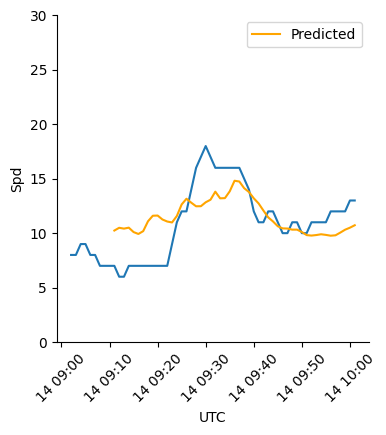

In [ ]:
# Pick which window from the test data to visualize (from 0 to 91)
window_choice = 81

# Pick which model to visualize
model_choice = model5

plot_window, plot_preds = get_plot_data(model=model_choice, window_num=window_choice)
create_prediction_plot(plot_window, plot_preds)

92/92 [==============================] - 10s 105ms/step


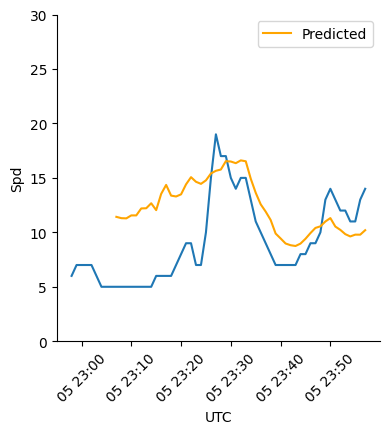

In [ ]:
# Pick which window from the test data to visualize (from 0 to 91)
window_choice = 25

# Pick which model to visualize
model_choice = model5

plot_window, plot_preds = get_plot_data(model=model_choice, window_num=window_choice)
create_prediction_plot(plot_window, plot_preds)

92/92 [==============================] - 10s 103ms/step


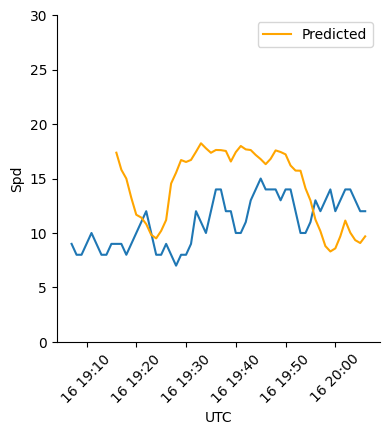

In [ ]:
# Pick which window from the test data to visualize (from 0 to 91)
window_choice = 44

# Pick which model to visualize
model_choice = model5

plot_window, plot_preds = get_plot_data(model=model_choice, window_num=window_choice)
create_prediction_plot(plot_window, plot_preds)

92/92 [==============================] - 10s 106ms/step


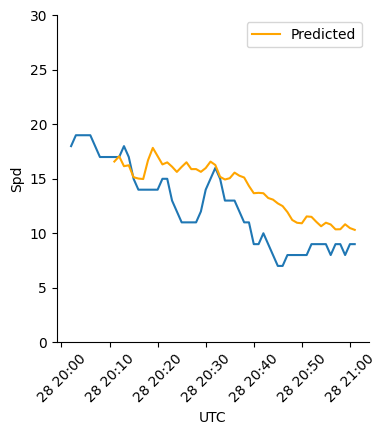

In [ ]:
# Pick which window from the test data to visualize (from 0 to 91)
window_choice = 76

# Pick which model to visualize
model_choice = model5

plot_window, plot_preds = get_plot_data(model=model_choice, window_num=window_choice)
create_prediction_plot(plot_window, plot_preds)

92/92 [==============================] - 8s 83ms/step


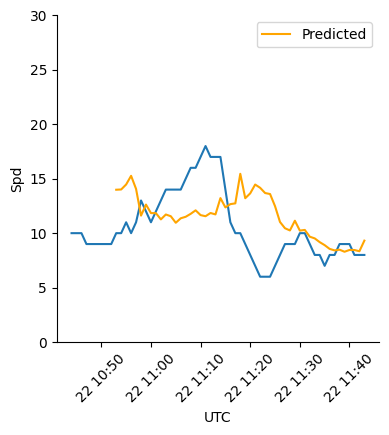

In [ ]:
# Pick which window from the test data to visualize (from 0 to 91)
window_choice = 29

# Pick which model to visualize
model_choice = model5

plot_window, plot_preds = get_plot_data(model=model_choice, window_num=window_choice)
create_prediction_plot(plot_window, plot_preds)